# 0) При реализации алгоритма разрешается использовать только библиотеки из requierments.txt

В него входит:
1. jupyter - библиотека для показа ноутбуков
2. numpy - библиотека для вычислений
3. matplotlib - библиотека для визуализации

## Установка 
1. Устанавливаем python3 и virtualenv
2. создаем окружение virtualenv --no-site-packages  lin_prog
3. активируем окружение source activate lin_prog
4. устанавливаем зависимости pip install -r requirements.txt
5. запускаем jupyter и начинаем работать jupyter notebook

# ============================================================
# Задача на Симплекс метод

## 1) На вход Вашему функцию должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.3 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например


### Дополнительная часть  (0.8 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)




In [446]:
import numpy as np
# Не печатать в лог сообщения о делении на ноль, ибо так и должно быть
np.seterr(divide='ignore', invalid='ignore')
import logging as log
import sys
#log.basicConfig(level=log.DEBUG, format='>%(message)s', stream=sys.stdout)
log.basicConfig(level=log.ERROR, format='>%(message)s', stream=sys.stdout)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

# Для тестирования было полезно, не стал удалять
from scipy.optimize import linprog

# Важно правильно сравнивать числа с плавающей точкой
epsilon=0.0000001
def float_equal(a, b):
    return abs(a-b)<epsilon

class eps:
    @staticmethod
    def lt(a, b):
        return a+epsilon<b
    
    @staticmethod
    def gt(a, b):
        return a>b+epsilon
    
    @staticmethod
    def le(a, b):
        return a<=b+epsilon
    
    @staticmethod
    def ge(a, b):
        return a>=b-epsilon
    
    @staticmethod
    def eq(a, b):
        return np.abs(a-b) <= epsilon
    
    @staticmethod
    def neq(a, b):
        return np.abs(a-b) > epsilon

In [447]:
class SP:
    def __init__(self, A, b, c, c_old=None):
        self.A = A
        b = b.reshape((-1, 1)).astype(np.float64)
        self.b = b
        self.c = c
        
        self.n = n = A.shape[0]
        self.m = m = A.shape[1]

        self.basis = np.array(list(range(0, n)))
        self.nonbasis = np.array(list(range(n, n+m)))
        
        # Сделаем симплекс-таблицу.
        self.ST = np.block([[A,  b],
                            [-c, 0]]).astype(np.float64)

        if c_old is None:
            self.c_old = None
        else:
            self.c_old = c_old
    
    def from_ST(self, ST, basis, nonbasis):
        self.ST = ST
    
    def get_solution(self):
        ST = self.ST
        basis = self.basis
        nonbasis = self.nonbasis
        n = self.n
        m = self.m
        
        x = np.zeros(m)
        w = np.zeros(n)
        for i in range(0, n):
            if 0<=basis[i]<n:
                w[basis[i]] = ST[:,-1][i]
            if basis[i]>=n:
                x[basis[i]-n] = ST[:,-1][i]
        log.info('x=%s, w=%s', x, w)
        
        if (self.A@x > self.b.reshape(1,-1)[0]+epsilon).any() or (x < -epsilon).any():
            raise Exception('Solution is infeasible')
        return x, w
    
    def __get_variables(self, method):
        ST = self.ST
        basis = self.basis
        nonbasis = self.nonbasis
        n = self.n
        m = self.m
        
        if method=='init_auxilary':
            if (eps.gt(ST[:, -1][:-1],0)).all():
                raise Exception('Problem is unbounded')
            #########i = np.argmin(ST[:, -1][:-1])
            i = np.argmin(ST[:, -1][:-1]) # "наиболее недопустимая" строчка.
            j = m-1 # т. е. всегда добавленная переменная
            log.info('j=%s'%j)
            log.info('i=%s'%i)
            return i, j
        if method=='largest_coef':
            j = np.argmin(ST[-1][:-1])
        elif method=='blend':
            #j = np.argmin(np.ma.array(nonbasis, mask=(ST[-1][:-1]>=-epsilon)))
            #j = nonbasis[(ST[-1][:-1]<0)][0]
            #j = np.where(ST[-1][:-1]<0+epsilon)[0][0]
            #ma = np.ma.masked_where(ST[-1, :-1] >= -epsilon, ST[-1, :-1])
            ma = np.ma.masked_where(eps.ge(ST[-1, :-1], 0), nonbasis)
            if ma.count() == 0:
                raise Exception("Something")
            #j = np.where(ma.mask == False)[0][0]
            j = np.argmin(ma)
        elif method=='lexical':
            j = np.argmin(ST[-1][:-1]) # любой
        else:
            raise Exception('Unknown method')
        
        ma = np.ma.masked_where(eps.le(ST[:-1, j], 0), ST[:-1, j])
        if (ma.count() == 0):
            raise Exception('Problem is unbounded')
        mb = ST[:-1, -1] # Маска в итоге поставится сама
        
        ratios = abs(mb/ma)
        #ratios = np.ma.masked_where(ratios > epsilon, ratios) # NEW TODO
        log.info('j=%s'%j)
        #ratios = ST[:, -1][:-1]/ST[:, j][:-1]
        log.debug('ratios %s'%ratios)
        i = np.where(eps.eq(ratio, ratios.min()))[0][0] #worked
        
#         ma = np.ma.masked_where(T[:-k, pivcol] <= tol, T[:-k, pivcol], copy=False)
#     if ma.count() == 0:
#         return False, np.nan
#     mb = np.ma.masked_where(T[:-k, pivcol] <= tol, T[:-k, -1], copy=False)
#     q = mb / ma
# return True, np.ma.where(q == q.min())[0][0]
        
        #i = np.argmin(np.ma.array(ratios, mask=(ratios<0+epsilon)))
        
        # Если у нас есть неоднозначность выбора
        if np.count_nonzero(eps.eq(ratios,  ratios[i]))>1:
            print('LLLLLLLLLLLLLLLLLLLLLLLLLL')
            if method=='lexical':
                # Делим каждую строчку на элемент, стоящий в столбце j
                ratios_row = ST[:-1] / ST[:-1, j].reshape(-1,1)
                print('ratios_row', ratios_row)
                ratios_row = np.hstack([ratios_row, np.arange(0, ratios_row.shape[0]).reshape(-1,1)])
                print(ratios_row)
                srt = np.lexsort(ratios_row[eps.eq(ratio, ratios.min())][:, ::-1].T)
                print(srt)
                print(ratios_row[srt[0]][-1])
                i = int(ratios_row[srt[0]][-1])
            elif method=='blend':
                print('min', ratios.min())
                #i = np.argmin(np.ma.array(basis, mask=np.logical_not(float_equal(ratios, ratios[i]))))
                #i = np.where(ratios == ratios.min())[0][0]
                i = np.argmin(np.ma.array(basis, mask=eps.neq(ratios, ratios[i])))
        log.info('i=%s'%i)
        return i, j
    
    def make_iteration(self, method):
        ST = self.ST
        basis = self.basis
        nonbasis = self.nonbasis
        n = self.n
        m = self.m
        
        #Разрешающий столбец
        i, j = self.__get_variables(method)

        basis[i], nonbasis[j] = nonbasis[j], basis[i]
        log.info("basis %s, nonbasis %s"%(basis, nonbasis))
        
        #Строим новую таблицу
        
        ST_ = -ST.copy()
        if self.c_old is not None:
            c_old = self.c_old.copy()
        
        ST_[i] = np.zeros(ST_.shape[1])
        ST_[i][j] = 1
        
        # S - матрица перехода
        S = np.eye(ST_.shape[1])
        S[j] = -ST[i]
        
        ST_ = -(np.linalg.inv(S.T)@ST_.T).T
        if self.c_old is not None:
            c_old = (np.linalg.inv(S.T)@c_old).T

        self.ST = ST_
        if self.c_old is not None:
            self.c_old = c_old
        
        log.info("%s"%self)
        return self
    
    def __str__(self):
        return "%s\nn=%s, m=%s, basis=%s, nonbasis=%s with c_old=%s"%(
            self.ST, self.n, self.m, self.basis, self.nonbasis, self.c_old)


In [448]:
def draw_all(sp, path):
    
    A = sp.A
    b = sp.b
    #c = sp.c
    
    def is_valid_solution(x):
        return (A@x.reshape((-1,1))<=b+epsilon).all() and (x>=0-epsilon).all()

    # Добавляем прямые ограничений типа >=0 в матрицы.
    A_plot = np.vstack([A, np.array([[1,0], [0,1]])])
    b_plot = np.vstack([b, [[0],[0]]])

    num_iter = len(path)
    plt.figure(figsize=(3, 3*(num_iter+1)))
    # Рисует ограничения, допустимые угловые точки отмечает чёрными точками, текущую - красной.
    for i, x in enumerate(path):
        plt.subplot(num_iter, 1, i+1)
        a = plt.gca()
        #plt.axes().set_aspect('equal')#, 'datalim')
        ##a.axis([-1, 17, -1, 17])
        a.set_aspect('equal')
        a.set_xlabel('X1')
        a.set_ylabel('X2')
        plt.title('Iteration %d x=(%.2f, %.2f)' % (i+1,x[0],x[1]))

        xmax, ymax = 0,0
        # Пересечения
        for i in range(0, A_plot.shape[0]):
            for j in range(0, i):
                if i != j:
                    a_, b_ = A_plot[i]
                    c_ = b_plot[i][0]
                    d_, e_ = A_plot[j]
                    f_ = b_plot[j][0]
                    #print(a_, b_, c_, d_, e_, f_)
                    x_ = (b_*f_-c_*e_)/(b_*d_-a_*e_)
                    y_ = (c_*d_-a_*f_)/(b_*d_-a_*e_)
                    if x_ > xmax and x_ != np.inf:
                        xmax = x_
                    if y_ > ymax and y_ != np.inf:
                        ymax = y_
                    #print(x_, y_)
                    if is_valid_solution(np.array([x_, y_])):
                        plt.scatter([x_], [y_], color='black', zorder=10)
        plt.scatter([x[0]], [x[1]], color='red', zorder=11)

        #print('xmax ymax', xmax, ymax)
        # Ограничения в виде осей (неотрицательность переменных)
        plt.plot([0, xmax], [0, 0], color='blue')
        plt.plot([0, 0], [ymax, 0], color='blue')
        border = 0.5
        plt.xlim((-border, xmax+border))
        plt.ylim((-border, ymax+border))

        # Ограничения
        for i in range(0, A_plot.shape[0]):
            a_, b_ = A_plot[i]
            c_ = b_plot[i][0]
            #print(a_, b_, c_)
            #print(c_/b_, c_/a_)
            #plt.plot([0, c_/a_], [c_/b_, 0], color='blue')

            if c_/b_<0:
                x1, y1 = c_/a_, 0
            else:
                x1, y1 = 0, c_/b_
            if (c_-a_*xmax)/b_ > ymax:
                x2, y2 = (c_-b_*ymax)/a_, ymax
            else:
                x2, y2 = xmax, (c_-a_*xmax)/b_
            if y2 < 0:
                x2, y2 = c_/a_, 0
            if x2 < 0:
                x2, y2 = 0, c_/b_
            plt.plot([x1, x2], [y1, y2], color='blue')

            if c_/a_<0:
                x1, y1 = 0, c_/b_
            else:
                x1, y1 = c_/a_, 0
            if (c_-a_*xmax)/b_ < ymax:
                x2, y2 = xmax, (c_-a_*xmax)/b_
            else:
                x2, y2 = (c_-b_*ymax)/a_, ymax
            if y2 < 0:
                x2, y2 = c_/a_, 0
            if x2 < 0:
                x2, y2 = 0, c_/b_
            plt.plot([x1, x2], [y1, y2], color='blue', zorder=-1)

            # Дорисовываем оси до нашей точки.
            #plt.plot([0, c_/a_], [0, 0], color='blue')
            #plt.plot([0, 0], [c_/b_, 0], color='blue')


    #plt.tight_layout()
    plt.show()

In [461]:
def solve_lin_prog (A, b, c, method='blend', start_point=None, draw=False):
    """
    Здесь должно быть ваше решение. У всех действий должны быть комментарии. 
    Код должен быть читабельным, хорошо использовать дополнительные функции если это необходимо
    
    A, b, c - матрица, b - вектор ограничений типа <=, с - функция полезности, задача максимизации
    method - 'blend', 'lexical'
    start_point - точка
    draw -  true/false рисовать ли ответ, только для 2 переменных
    
    Вывод - вектор на котором достигается максимум, максимальное значение, число итераций
    """
    
    if start_point is not None:
        basis_places = start_point == 0
    
    sp = None
    
    # Если есть отрицательные значения в b, запускаем инициализацию
    if (b < 0).any():
        log.info('INITIAL PROBLEM:')
        log.info(SP(A, b, c))
        
        log.info("             AUXILARY PROBLEM:")
        A_ = np.hstack([A, -np.ones((A.shape[0], 1))])
        b_ = b
        c_ = np.hstack([np.zeros(A.shape[1]), [-1]])
        sp = SP(A_, b_, c_, c_old=np.hstack([c.copy(), [0, 0]]))
        log.info(sp)
        
        log.info("First step")
        sp = sp.make_iteration('init_auxilary')
        
        
        iteration_number = 0
        #while np.min(sp.ST[-1][:-1]) < 0:
        while (eps.lt(sp.ST[-1][:-1], 0)).any():
            iteration_number += 1
            log.info('          AUXILARY ITERATION #%s'%iteration_number)

            sp = sp.make_iteration(method)

            x, w = sp.get_solution()
        
        # Если добавленная переменная ненулевая, задача недопустима
        if len(np.argwhere(sp.nonbasis == sp.n+sp.m-1)) == 0:
            raise Exception("Problem is infeasible")
        i = np.argwhere(sp.nonbasis == sp.n+sp.m-1)[0][0]
        sp.ST = np.delete(sp.ST, i, 1)
        #print(sp.c_old)
        
        #sp.c = np.delete(sp.c_old, i)
        sp.c = c
        sp.A = A
        sp.b = b.reshape(-1,1)
        sp.ST[-1] = -np.delete(sp.c_old, i)
        sp.nonbasis = np.delete(sp.nonbasis, i)
        sp.m -= 1
        sp.c_old = None
        sp.ST[-1][-1] *= -1
    else:
        sp = SP(A, b, c)
    
    log.info("SOLVING PROBLEM:")
    log.info(sp)
    
    iteration_number = 0
    
    
    # Начальное решение
    x, w = sp.get_solution()
    
    solutions = [x]
    
    while (sp.ST[-1][:-1] < 0).any():
        iteration_number += 1
        log.info('          ITERATION #%s'%iteration_number)
        
        sp = sp.make_iteration(method)
        
        x, w = sp.get_solution()
        solutions.append(x)
    
    log.info('FINISHED in %d iterations'%iteration_number)
    
    log.info('path %s'%solutions)
    x, w = sp.get_solution()
    
    log.info('SOLUTIONS %s'%solutions)
    
    if draw == True and sp.m != 2:
        raise Warning("Can't draw with dim != 2")
        
    if draw == True:
        draw_all(sp, solutions)
    
    #assert(sp.ST[-1][-1] == sp.c @ x)
    return x, sp.c @ x, iteration_number


def solve_dual(A, b, c, draw=False):
    return solve_lin_prog(-A.T, -c, -b, draw=draw)

In [462]:
def callback(xk, **kwargs):
    print('X', xk)
    print(kwargs)
# Пример, который циклится   
c = -np.array([-10, 57, 9, 24.])
A = np.array([[0.5, -5.5, -2.5, 9],
                     [0.5, -1.5, -0.5, 1],
                     [1, 0, 0, 0]])
b = np.array([0, 0, 1])
#print(linprog(-c, A_ub=A, b_ub=b, options=dict(bland=True), callback=callback))

ans = solve_lin_prog(A, b, c, method='blend')
print(ans)
corr_ans = (np.array([ 1.,  0.,  1.,  0.]), 1.0)
assert((float_equal(ans[0], corr_ans[0])).all() and float_equal(ans[1], corr_ans[1]).all())

LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 1.0
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 2.0
(array([ 1.,  0.,  1.,  0.]), 1.0, 6)


In [463]:
# Пример, который циклится
A=np.array([[0.5,-3.5,-2, 4],[0.5, -1, -0.5, 0.5], [1, 0, 0, 0]])
b=np.array([0,0,1])
c=np.array([1, -2, 0, -2])
print(linprog(-c, A_ub=A, b_ub=b, options=dict(bland=True, tol=1e-8, maxiter=10 ** 6)))
ans = solve_lin_prog(A, b, c, method='blend')
corr_ans = (np.array([ 1.,  0.,  1.,  0.]), 1.0)
print(ans)


     fun: -0.99999999999999978
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([ 1.5,  0. ,  0. ])
  status: 0
 success: True
       x: array([ 1.,  0.,  1.,  0.])
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 0.0
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 1.0
LLLLLLLLLLLLLLLLLLLLLLLLLL
min 1.5
(array([ 1.,  0.,  1.,  0.]), 1.0, 6)


In [464]:
#method = 'largest_coef'
method = 'blend'

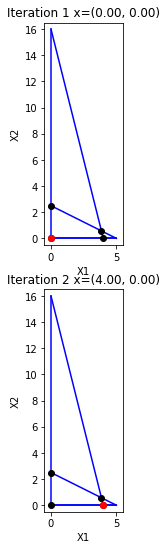

(array([ 4.,  0.]), 20.0, 1)


In [465]:
# Пример ненулевой начальной точки
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
ans = solve_lin_prog(A, b, c, draw=True, method='largest_coef', start_point=np.array([0, 5]))
corr_ans = (np.array([ 4.,  0.]), 20.0)
print(ans)

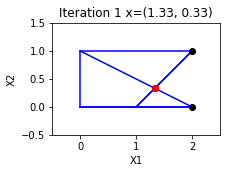

(array([ 1.33333333,  0.33333333]), -3.0000000000000004, 0)


In [466]:
# Пример инициализации
A=np.array([[-1,1],[-1, -2], [0, 1]])
b=np.array([-1, -2, 1])
c=np.array([-2, -1])
ans = solve_lin_prog(A, b, c, method='largest_coef', draw=True)
corr_ans = (np.array([ 1.33333333,  0.33333333]), -3)
print(ans)
assert((float_equal(ans[0], corr_ans[0])).all() and float_equal(ans[1], corr_ans[1]).all())

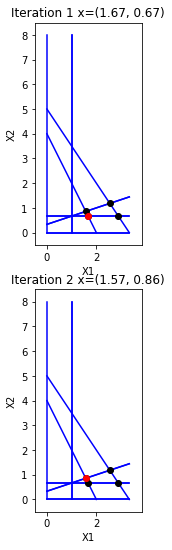

(array([ 1.57142857,  0.85714286]), -1.2857142857142856, 1)


In [467]:
# Пример инициализации
A = np.array([[-4,-2],[-2,0], [3,2],[-1,3], [0,-3]])
b = np.array([-8,-2,10,1,-2])
c = np.array([-3,4])
ans = solve_lin_prog(A, b, c, method=method, draw=True)
print(ans)
corr_ans = (np.array([ 1.57142857,  0.85714286]), -1.2857142857142856)
assert((float_equal(ans[0], corr_ans[0])).all() and float_equal(ans[1], corr_ans[1]).all())

In [468]:
# Пример неограниченной задачи
A=np.array([[-1,-1],[-2, -1]])
b=np.array([1, 2])
c=np.array([2, 1])
try:
    ans = solve_lin_prog(A, b, c, method=method, draw=True)
except Exception as e:
    print(e)


Problem is unbounded


In [391]:
# Пример недопустимой задачи
A=np.array([[1,1],[-1, -1]])
b=np.array([1, -2])
c=np.array([-2, -1])
try:
    ans = solve_lin_prog(A, b, c, method=method, draw=True)
except Exception as e:
    print(e)

Problem is infeasible


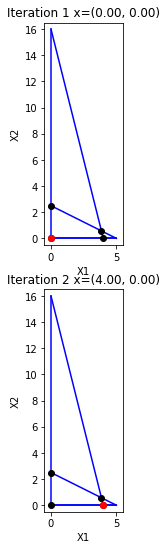

(array([ 4.,  0.]), 20.0, 1)


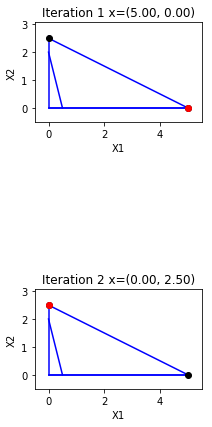

(array([ 0. ,  2.5]), -20.0, 1)


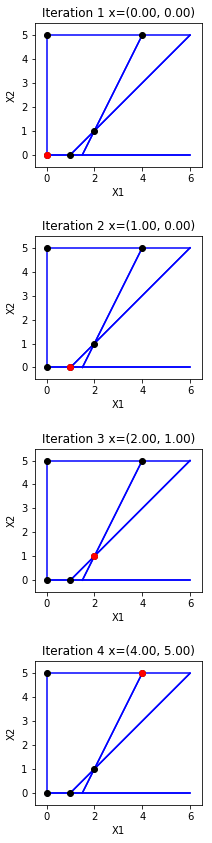

(array([ 4.,  5.]), 31.0, 3)
Something
(array([ 2.,  0.,  1.]), 13.0, 2)
(array([ 1.,  0.,  1.]), -13.0, 1)
(array([  0.,  15.,   0.,  25.]), 145.0, 5)
(array([ 3.5,  0. ,  0.5]), -145.0, 1)


In [394]:
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
ans = solve_lin_prog(A, b, c, draw=True, method=method)
print(ans)
corr_ans = (np.array([ 4.,  0.]), 20.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    ans = solve_dual(A, b, c, draw=True)
    print(ans)
    corr_ans = (np.array([ 0. ,  2.5]), -20.0, 0)
    assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
except Exception as e:
    print(e)

A=np.array([[1,-1],[2,-1], [0, 1]])
b=np.array([1,3,5])
c=np.array([4,3])
ans = solve_lin_prog(A, b, c, draw=True, method=method)
print(ans)
corr_ans = (np.array([ 4.,  5.]), 31.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    ans = solve_dual(A, b, c, draw=True)
    print(ans)
    #corr_ans = (array([ 0. ,  2.5]), -20.0, 0)
    #assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
except Exception as e:
    print(e)
#print(is_optimal(A,b,c,x))

A=np.array([[2,3,1],[4,1,2],[3,4,2]])
b=np.array([5, 11, 8])
c=np.array([5, 4, 3])
ans = solve_lin_prog(A, b, c, method=method)
print(ans)
corr_ans = (np.array([ 2.,  0.,  1.]), 13.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    ans = solve_dual(A, b, c, draw=False)
    print(ans)
    #corr_ans = (array([ 0. ,  2.5]), -20.0, 0)
    #assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
except Exception as e:
    print(e)

A=np.array([[1,1,1,1],[2,1,-1,-1],[0,-1,0,1]])
b=np.array([40, 10, 10])
c=np.array([0.5, 3,1,4])
ans = solve_lin_prog(A, b, c, method=method)
print(ans)
corr_ans = (np.array([  0.,  15.,   0.,  25.]), 145.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    ans = solve_dual(A, b, c, draw=False)
    print(ans)
    corr_ans = (np.array([ 3.5,  0. ,  0.5]), -145.0, 1)
    assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
except Exception as e:
    print(e)

In [395]:
def is_optimal (A,b,c, x):
    """
    Здесь должна быть реализована проверка оптимальности точки. 
    Алгоритм должен работать для фиксированных n,m за константное время
    """
    # Если точка недопустима, она не оптимальна
    if (A@x>b).any() or (x < 0).any():
        return False
    
    # Берём двойственную задачу
    A_ = -A.T
    c_ = -b
    b_ = -c
    log.debug(A_, b_, c_)
    
    # Теорема о комплементарной фиктивности: 
    # если неравенства обращаются в равенства, то соответствующие фиктивные переменные не 0,
    # соответствующие переменные двойственной задачи не 0
    not_zeros_in_primal = (x != 0)
    not_zeros_in_dual = (A@x == b)
    log.debug('mask %s'%not_zeros_in_primal, not_zeros_in_dual)
    log.debug('A_cut %s'%A_[:, not_zeros_in_dual][not_zeros_in_primal])
    log.debug('b_cut %s'%b_[not_zeros_in_primal])
    x_nonzero = (np.linalg.inv(np.matrix(A_[:, not_zeros_in_dual][not_zeros_in_primal]))@b_[not_zeros_in_primal]).A1
    log.info("x_nonzero %s"%x_nonzero)
    
    x_ = np.zeros(A_.shape[1])
    x_[not_zeros_in_dual] = x_nonzero
    log.info('x %s'%x_)
    # Если для двойственной задачи её точка недопустима, то для прямой точка была не оптимальной.
    if (A_@x_ > b_+epsilon).any() or (x_ < -epsilon).any():
        return False
    
    return True

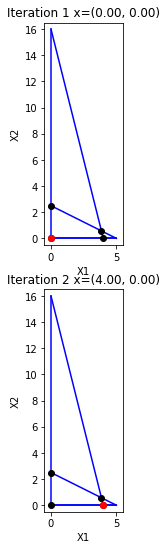

(array([ 4.,  0.]), 20.0, 1)
True
False
False


In [396]:
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
print(solve_lin_prog(A, b, c, draw=True))
x=np.array([4,0])
print(is_optimal(A,b,c,x))
x=np.array([0,2.5])
print(is_optimal(A,b,c,x))
x=np.array([0,0])
print(is_optimal(A,b,c,x))

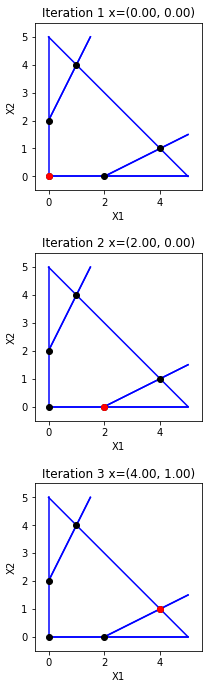

True
False
False
False
False


In [397]:
c = np.array([1, -1])
A = np.array([[-2, 1],
              [1, -2],
              [1, 1]])
b = np.array([2, 2, 5])
#x = np.array([1,4])
solve_lin_prog(A, b, c, draw=True)
x = np.array([4,1])
print(is_optimal(A,b,c,x))
x = np.array([1,4])
print(is_optimal(A,b,c,x))
x = np.array([0,2])
print(is_optimal(A,b,c,x))
x = np.array([2,0])
print(is_optimal(A,b,c,x))
x = np.array([0,0])
print(is_optimal(A,b,c,x))

# ==========================================================
# Задача на МНК (0.4 балла)

* Для `method=0` решается обычным образом: $x = (A^TA)^{-1}A^Tb$ (было на лекции, нет смысла объяснять).
Здесь $A = 
\begin{pmatrix}
\dots\\
\sin t_i & t_i & 1\\
\dots 
\end{pmatrix}$
 
Для всех $i$ записывается $(a_2\sin t_i, a_1 t_i, a_0)$ как $A \cdot \begin{pmatrix}a_2\\a_1\\a_0\end{pmatrix}$

* Для `method=1` сведём к задаче линейного программирования:
$\sum_i |a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr}| \rightarrow \min $

$\Leftrightarrow
\begin{cases}
    |a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr}| \le y_i^{err} \forall i\\
    \sum y_i^{err} \rightarrow \min
 \end{cases}$, где $y_i^{err}$ -- число, обозначающее ошибку по данной координате
 
$\Leftrightarrow 
 \begin{cases}
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \le y_i^{err} \forall i\\
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \ge -y_i^{err} \forall i\\
    \sum y_i^{err} \rightarrow \min
 \end{cases}$

Тогда задача сводится к
$c^Tx \rightarrow \min\\
\begin{pmatrix}
-E & A\\
-E & -A
\end{pmatrix} x \le \begin{pmatrix}y^{corr}\\-y^{corr} \end{pmatrix}$

где $x = (y^{err}_1,\dots,y^{err}_n,a_2,a_1,a_0), c = (1, \dots, 1, 0, 0, 0)$.

Наша реализация симплекс-метода максимизирует, поэтому домножим $c$ на $-1$.

* Для `method=2`:
$\max_i |a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr}| \rightarrow \min $
$\Leftrightarrow 
 \begin{cases}
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \le y^{err} \forall i\\
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \ge -y^{err} \forall i\\
    y^{err} \rightarrow \min
 \end{cases}$
 
$\Leftrightarrow$ (для такой же A)

$c^Tx \rightarrow \min\\
\begin{pmatrix}
\begin{pmatrix}-1\\ \vdots \\ -1 \end{pmatrix} & A\\
\begin{pmatrix}-1\\ \vdots \\ -1 \end{pmatrix} & -A
\end{pmatrix} x \le \begin{pmatrix}y^{corr}\\-y^{corr} \end{pmatrix}$

где $x = (y^{err},a_2,a_1,a_0), c = (1, 0, 0, 0)$

In [470]:
from math import sin
import numpy as np

"""Пусть физический закон описывается зависимостью 
некоторого измеряемого значения y(x, a) 
от времени и координаты x при параметрах a:"""
def y(t,a): 
    return a[2]*sin(t)+a[1]*t +a[0]

def y_vector(t, a):
    return [y(t_, a) for t_ in t]

"""
Дан набор координат t размера m, значения распределены равномерно). Пусть m = 200.
"""
m = 50
t=[i*10.0/m for i in range(m)]


"""Для каждого момента времени t сгенерируйте соответствующее 
значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера: """
a=[10,100,1000]

def get_y (a, σ):
    """Результаты измерений отличаются от истинных значений в силу действия случайной аддитивной помехи 
    (случайность подчиняется нормальному закону распределения N(0, σ))"""
    y_real=np.array([y(i,a) for i in t])
    y_corr=y_real+np.random.normal(0,σ,m)
    return y_real, y_corr

#todo -выбрать параметр
#σ=0.5
σ=200

# генерация значений. изначальные и с помехами
y_real, y_corr= get_y(a,σ)

def solve_overdefined_system(A, b, method=0):
    A = np.matrix(A)
    b = b
    if method == 0:
        return ((A.T@A).I @ A.T @ b).A1
    elif method == 1:
        E = np.eye(A.shape[0])
        A_ = np.bmat([[-E, A],
                      [-E, -A]]).A
        b_ = np.hstack([b, -b])
        c_ = -np.hstack([np.ones(A.shape[0]), np.zeros(A.shape[1])]) # Точно с минусом?

        x, _, _ = solve_lin_prog(A_, b_, c_, method='largest_coef')
        return x[-A.shape[1]:]
#         x = linprog(-c_, A_ub=A_, b_ub=b_, options=dict(bland=True, tol=1e-8, maxiter=10 ** 6))
#         return x.x[-A.shape[1]:]
    elif method == 2:
        ones = np.ones(A.shape[0]).reshape(-1,1)
        A_ = np.bmat([[-ones, A],
                      [-ones, -A]]).A
        b_ = np.hstack([b, -b])
        c_ = -np.hstack([[1], np.zeros(A.shape[1])])
        
        x, _, _ = solve_lin_prog(A_, b_, c_)
        return x[-A.shape[1]:]
#         x = linprog(-c_, A_ub=A_, b_ub=b_, options=dict(bland=True, tol=1e-8, maxiter=10 ** 6))
#         return x.x[-A.shape[1]:]
        

# Я решил вынести функцию наружу для большей универсальности.
def get_params (y_corr, t, func, method=0):
    """
    По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    •	method=0 -> сумма квадратов невязок будет минимальна.
    •	method=1 -> сумма абсолютных значений невязок будет минимальна.
    •	method=2 -> максимальное абсолютное значение невязки будет минимально.
    
    #todo - написать ф-ю
    """
    A = np.matrix([func(t_) for t_ in t])
    return solve_overdefined_system(A, y_corr, method=method)


## Задание 1 (0.2 балла)
1.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?
3.	Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

In [471]:
def analyze_approximation(t, y_corr):
    plt.figure(figsize=(10, 5))
    plt.plot(t, y_vector(t, a), color='black')
    plt.scatter(t, y_corr, color='gray', alpha=0.5)
    
    a_est = get_params(y_corr, t, lambda t_:[1, t_, np.sin(t_)], method=0)
    print('For method=0', a_est)
    plt.plot(t, y_vector(t, a_est), color='r', label='For method=0')
    
    a_est = get_params(y_corr, t, lambda t_:[1, t_, np.sin(t_)], method=2)
    print('For method=2', a_est)
    plt.plot(t, y_vector(t, a_est), color='b', label='For method=2')
    
    a_est = get_params(y_corr, t, lambda t_:[1, t_, np.sin(t_)], method=1)
    print('For method=1', a_est)
    plt.plot(t, y_vector(t, a_est), color='g', label='For method=1')
    
    plt.legend()
    plt.ylim(-2000, 2000)
    plt.show()

For method=0 [   32.27116379    98.50460131  1008.17435444]
For method=2 [    0.           108.70842259  1048.13301182]
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
For method=1 [   69.51139991    93.68853077  1007.77235421]


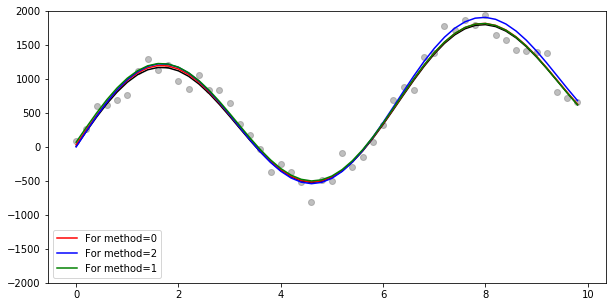

In [472]:
analyze_approximation(t, y_corr)

For method=0 [ 1156.37467769  -135.51483067  1127.87568582]
For method=2 [ 1782.39502905     0.          7663.15004977]
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLL
For method=1 [   60.06938132    91.17891586  1021.13397892]


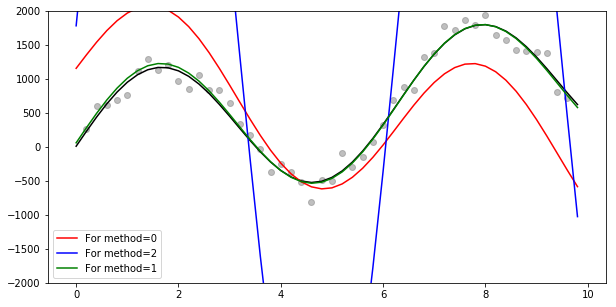

In [473]:
y_corr_with_outlier = y_corr.copy()
outlier = 10000
y_corr_with_outlier[0] += outlier
y_corr_with_outlier[-1] -= outlier

analyze_approximation(t, y_corr_with_outlier)

Хуже всего аппроксимирует method=2, он же совсем неустойчив к выбросам.
method=1 аппроксимирует слегка лучше МНК, но более устойчив к выбросам, чем method=0
method=0 — обычный МНК — довольно хорошо аппроксимирует и довольно устойчив к выбросам. К тому же, он не требует для своей работы симплекс-метода и поэтому работает быстрее. Кажется, что лучше использовать для практических нужд именно его и минимизировать именно в смысле наименьших квадратов, когда это возможно.

## Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

1. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.
2. Постройте распределение ошибок для каждого решения.
3. Какими свойствами обладают распределения?

In [ ]:
A = np.random.normal(size=(200, 80))
b = np.random.normal(size=(200))

x0 = solve_overdefined_system(A, b, method=0)
x2 = solve_overdefined_system(A, b, method=2)
x1 = solve_overdefined_system(A, b, method=1)

In [ ]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

plt.figure()
plt.plot(*ecdf(b-A@x0), color='r', label='For method=0')
plt.plot(*ecdf(b-A@x1), color='g', label='For method=1')
plt.plot(*ecdf(b-A@x2), color='b', label='For method=2')
plt.show()

plt.figure()
plt.hist(b-A@x0)
plt.show()
plt.hist(b-A@x1)
plt.show()
plt.hist(b-A@x2)

plt.show()

## Бонус +1 Балл
Напишите программу которая для обоих методов из задачи 5 будет использовать 2^n-1 итераций (бонус за каждый метод) и напишите обоснование (итого 0.5 балла за каждый метод)

Лексикографический метод влияет только на выбор выходящей переменной. Выбор входящей же может осуществляться любым методом, в том числе методом наибольшего коэффициента. Для него известен простой пример, для которого время работы $2^n-1$ — деформированный гиперкуб Кли-Минти. Там будут обязательно обойдены все вершины.

Он строится так:


In [278]:
def generate_killer_sequence(n, method='blend'):
    if method=='lexical':
        c = np.array([10**i for i in range(n, 0, -1)])
        b = np.array([100**i for i in range(0, n)])
        A = np.eye(n)
        for i in range(0, n):
            for j in range(0, i):
                A[i, j] = 2*10**(i-j)
        return A, b, c
    elif method=='lexical2':
        a = 5 # >= 3
        c = np.array([a**i for i in range(n, 0, -1)])
        b = np.array([a**(2*(i-1)) for i in range(0, n)])
        A = np.eye(n)
        for i in range(0, n):
            for j in range(0, i):
                A[i, j] = 2*a**(i-j)
        return A, b, c
    elif method=='blend':
        a = 0.1 # 0 < a <1/3
        c = np.array([a**i for i in range(n, 0, -1)])
        b = np.array([1 for i in range(0, n)])
        A = np.eye(n)
        for i in range(0, n):
            for j in range(0, i):
                A[i, j] = 2*a**(i-j)
        return A, b, c
    elif method=='blend2':
        a = 0.1 # 0 < a <1/3
        c = np.zeros(2*n)
        for i in range(0, n):
            c[2*i] = a**(n-i)
        b = np.array([1 for i in range(0, 2*n, 2)])
        A = np.zeros((n, 2*n))
        for i in range(0, n):
            A[i, 2*i] = 1
            for j in range(0, i):
                A[i, 2*j] = 2*a**(i-j)
        return A, b, c

In [279]:
for i in range(2, 5):
    A, b, c = generate_killer_sequence(i, method='lexical2')
    #print(A, b, c)
    x, f, n_iter = solve_lin_prog(A, b, c, method='lexical')
    print(x, f, n_iter)
    assert (2**i-1 == n_iter)
print("Success")

[ 0.  1.] 5.0 3
[  0.   0.  25.] 125.0 7
[   0.    0.    0.  625.] 3125.0 15
Success


In [280]:
for i in range(2, 5):
    A, b, c = generate_killer_sequence(i, method='blend2')
    print(A, b, c)
    #x, f, n_iter = solve_lin_prog(A, b, c, method='blend')
    #print(x, f, n_iter)
    ans = linprog(-c, A_ub=A, b_ub=b, options=dict(bland=True))
    print(ans.nit)
    assert (2**i-1 == ans.nit)

[[ 1.   0.   0.   0. ]
 [ 0.2  0.   1.   0. ]] [1 1] [ 0.01  0.    0.1   0.  ]
3
[[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.2   0.    1.    0.    0.    0.  ]
 [ 0.02  0.    0.2   0.    1.    0.  ]] [1 1 1] [ 0.001  0.     0.01   0.     0.1    0.   ]
5


AssertionError: 

In [34]:
# Avis-Chvatal example
# https://link.springer.com/chapter/10.1007/BFb0121192
a = 2
c = np.array([a**2,a,1])  # maximize
A = np.array([[1, 0, 0],
              [2*a, 1, 0],
              [2*a**2,2*a, 1]])
b = np.array([5, 25, 125])

# a = 0.1
# c = np.array([a**2,a,1])  # maximize
# A = np.array([[1, 0, 0],
#             [2*a, 1, 0],
#             [2*a**2,2*a, 1]])
# b = np.array([1, 1, 1])

# c = np.array([a,1])  # maximize
# A = np.array([[1, 0],
#             [2*a, 1]])
# b = np.array([1, 1])

print(linprog(-c, A_ub=A, b_ub=b))
solve_lin_prog(A, b, c, method='blend')

     fun: -125.0
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([  5.,  25.,   0.])
  status: 0
 success: True
       x: array([   0.,    0.,  125.])


(array([   0.,    0.,  125.]), 125.0, 5)